In [195]:
# Data 
start_x = 0           # start position of the vehicle
destination = 800     # position of destination
idle_fuel = 0.1/3600  # gallons per second consumed when vehicle stops with engine on
max_v = 19            # maximum speed limit on the route
min_a = -5            # minimum acceleration, limit of the vehicle, m/s^2
max_a = 5             # maximum acceleration, limit of the vehicle, m/s^2
T = 180               # maximum time to reach destination, in seconds
  
# traffic lights data 
n_lights = 3                         # number of lights on the route
traf_pos = [300, 500, 700]           # positions of the traffic lights 
t_green_duration = [10, 25, 20]      # how long light stays green for traffic light i 
t_red_duration = [20, 24, 24]        # how long light stays yellow + red for traffic light i, yellow is before red
start_color = [0, 1, 0]              # with which color light cycle starts for traffic light i, [red, green,red]

#=
 Values necessary for SOS2 constraint. 
 Piecewise Linear Function to map velocity to fuel consumed at that velocity
    
    y1 = 0.1*(-13/2*v[i]+59)
    y2 = 0.1*7
    y3 = 0.1*(3/4*v[i]-17/4)

=#
v_end_point = [8, 8, 15]
v_func = [0.7, 0.7, 0.7]
l = [-8, 7, 4]
l_abs = abs(l)
l_sign = [-1, 1, 1]
g = [-13/20, 0, 3/40];

In [196]:
# Values for each traffic light at each second that define how long it remains red or green 
t_g = Array{Int64, 2}(n_lights, T)     # number of seconds left until traffic light i turns green for each jth second  
t_r = Array{Int64, 2}(n_lights, T)     # number of seconds left until traffic light i turns red for each jth second

# start_color = 0 means red, start_color = 1 means green 
# k - index of the traffic light
# This function helps to assign the start color to the traffic light k.
function init_lights(start_color,k)
    if start_color==0  # if red 
        for i=1:T
            j = i%(t_red_duration[k] + t_green_duration[k])
            if j<=(t_red_duration[k]-1)
                t_g[k, i] = t_red_duration[k] - j + 1
                t_r[k, i] = 0
            else
                t_g[k, i] = 0
                t_r[k, i] = t_green_duration[k] - j + t_red_duration[k]
            end
        end
    else             # if green 
        for i=1:T
            j = i%(t_red_duration[k] + t_green_duration[k])
            if j<=(t_green_duration[k]-1)
                t_g[k, i] = 0
                t_r[k, i] = t_green_duration[k] - j + 1
            else
                t_g[k, i] = t_red_duration[k] - j + t_green_duration[k]
                t_r[k, i] = 0
            end
        end
    end
end

# Set the start color and cycle of the traffic lights 
for i=1:n_lights
    init_lights(start_color[i], i)
end

In [197]:
using JuMP, Gurobi

m = Model(solver=GurobiSolver(OutputFlag = 0))

########################################## Variables #########################################

@variable(m, x[1:T] >=0 )                 # position at time t
@variable(m, 0 <= v[1:T] <= max_v)        # velocity at time t
@variable(m, min_a <= a[1:T-1] <= max_a)  # acceleration at time t      
@variable(m, w[1:T-1])                    # epigraph variable for the abs val of difference in velocity
@variable(m, w_a[1:T-2])                  # epigraph variable for the abs val of difference in acceleration (jerk)

# Binary variables for logical constraints z[k,i], kth light and ith second

@variable(m, z_1[1:n_lights, 1:T], Bin)   # iff z_1=1 then x[i] >= traf_pos of light k
@variable(m, z_2[1:n_lights, 1:T], Bin)   # iff z_2=1 then x[i] <= traf_pos of light k
@variable(m, z_3[1:n_lights, 1:T], Bin)   # if z_1=1 and z_2=1 then z_3 = 1; i.e. x[i] == traf_pos of light k
@variable(m, z_4[1:n_lights, 1:T], Bin)   # if x[i]>= traf_pos[k]-max_v then z_4=1
@variable(m, z_5[1:n_lights, 1:T], Bin)   # if x[i]<= traf_pos[k] then z_5=1
@variable(m, z_6[1:n_lights, 1:T], Bin)   # if z_4=1 and z_5=1 then z_6=1

# Binary variables for the logical constraints on the position and velocity of vehicle
@variable(m, z_7[1:T], Bin)              # if v[i]<=0 then z_7 = 1
@variable(m, z_8[1:T], Bin)              # if x[i]<=destination then z_8 = 1
@variable(m, z_9[1:T], Bin)              # if x[i]<=destination (z_8=1) and v[i]<=0 (z_7=1) then z_9 = 1

# Variables for the SOS2 constraint
@variable(m, z_p[1:T,1:3], Bin)
@variable(m, lambda[1:T,1:3] >= 0)

########################################## Constraints #########################################

@constraint(m, dynamics[i in 1:T-1], x[i+1] == x[i] + a[i]/2 + v[i]) # x = at^2*0.5 + vt
@constraint(m, velocity_change[i in 1:T-1], v[i+1] == v[i] + a[i])   # v = v_initial + at 
@constraint(m, x[T] == destination)                                  # we need to reach destination 
@constraint(m, x[1] == start_x)                                      # we need to start at given pos
@constraint(m, v[1] == 0)                                            # start at rest 
@constraint(m, v[T] == 0)                                            # end at rest

# SOS2 constraints to ensure choosing two consecutive end points of segments in 
# piecewise linear function, v vs fuel 
for i in 1:T
    @constraint(m, lambda[i,1] <= l_abs[1]*z_p[i,1])
    @constraint(m, lambda[i,2] <= l_abs[2]*(z_p[i,2] + z_p[i,1]))
    @constraint(m, lambda[i,3] <= l_abs[3]*(z_p[i,2] + z_p[i,3]))
    @constraint(m, sum(lambda[i,:]) <= sum(l_abs))
end
@expression(m, obj_t[i in 1:T], sum(z_p[i,j]*v_func[j] + l_sign[j]*g[j]*lambda[i,j] for j=1:3))
@expression(m, v_value[i in 1:T], sum(z_p[i,j]*v_end_point[j] + l_sign[j]*lambda[i,j] for j=1:3))
for i in 1:T                                    
    @constraint(m, v_value[i] == v[i])
end 
                                                                 
for i=1:T-1
    # Epigraph constraint for abs value of acceleration 
    @constraint(m, w[i] >= a[i])
    @constraint(m, -w[i] <= a[i])
    
    # Epigraph constraint for abs value of difference in acceleration
    if i <= T-2
        @constraint(m, w_a[i] >= a[i+1]-a[i])
        @constraint(m, -w_a[i] <= a[i+1]-a[i])
    end
end

# Constraints to check whether vehicle should stop or move when it's close to the traffic light
for k = 1:n_lights
    for i=1:T
        
        # constraints for checking if x[i] == traf_pos[k] 
        @constraint(m, x[i]- traf_pos[k] <= traf_pos[k]*2*z_1[k, i] - (1-z_1[k, i])) 
        @constraint(m, x[i] - traf_pos[k] >= -traf_pos[k]*(1-z_1[k, i]))
        @constraint(m, x[i]- traf_pos[k] >= -traf_pos[k]*z_2[k, i] + (1-z_2[k, i]))
        @constraint(m, x[i]- traf_pos[k] <= traf_pos[k]*2*(1-z_2[k, i])) 
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 <= 2*z_3[k, i] - (1-z_3[k, i]))
        @constraint(m, z_1[k, i] + z_2[k, i] - 2 >= -2*(1-z_3[k, i]))
                                
        # constraints for x[i] being close to traf_pos[k]
        @constraint(m, x[i] - (traf_pos[k]-max_v) <= traf_pos[k]*2*z_4[k, i] - 0.1*(1-z_4[k, i]))
        @constraint(m, x[i] - (traf_pos[k]-max_v) >= -(traf_pos[k]-max_v)*(1-z_4[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) >= -(traf_pos[k])*z_5[k, i] + 0.1(1-z_5[k, i]))
        @constraint(m, x[i] - (traf_pos[k]) <= traf_pos[k]*2*(1-z_5[k, i]))
        @constraint(m, z_4[k, i] + z_5[k, i] - 2 <= 2*z_6[k, i] - (1-z_6[k, i]))
        @constraint(m, z_4[k, i] + z_5[k, i] - 2 >= -2*(1-z_6[k, i]))

        # enters this loop if light is red, t_g is positive 
        for j=i:i+t_g[k, i]
            if j<=T
                # if z_6=1 then x[i+1] ... x[i+t_g[i]] <= traf_pos[k] 
                # if it is red color, and you are close to the traf_pos[k], don't cross red light until green  
                @constraint(m, x[j]-(traf_pos[k]) <= 2*(traf_pos[k])*(1-z_6[k, i])) 
                # if z_3=1 then v[j] = 0, last speed =0 when stops
                # if it is red and you are exactly at traf_pos[k], stop immediately 
                @constraint(m, v[j] <= max_v*(1-z_3[k, i]))                
            end
        end
    end
end

for i=1:T
                            
    # z_7[i] = 1, if v[i]=0, ignore first and last as they are defined to be 0
    if i>=2 && i <= T-1
        @constraint(m, v[i] >= -0.1*z_7[i]+(1-z_7[i]))
        @constraint(m, v[i] <= max_v*(1-z_7[i]))
    end
                            
    # this constraint is necessary to check whether x[i] is less than destination                
    @constraint(m, x[i] - (destination-0.01) >= -(destination-0.01)*z_8[i] + 0.01(1-z_8[i])) 
    @constraint(m, x[i] - (destination-0.01) <= destination*2*(1-z_8[i]))  # if z_8=1 then x<= dest-0.01
    
    # if x[i] >= destination, means our velocity is 0, then do not count fuel after that point  
    # else use the piecewise linear function defined for velocity vs fuel
    @constraint(m, sum(z_p[i,:]) <= z_8[i])         # if z_8==0 then sum(z_p)<=0
    @constraint(m, sum(z_p[i,:]) >= z_8[i])         # if z_8==0 then sum(z_p)>=0
    @constraint(m, sum(z_p[i,:])-1 >= -1(1-z_8[i])) # if z_8==1 then sum(z_p)>=1
    @constraint(m, sum(z_p[i,:])-1 <= -1(1-z_8[i])) # if z_8==1 then sum(z_p)<=1   
                            
    # count the number of times speed is 0 only when x[i]<destination to count idling time 
    @constraint(m, z_7[i] + z_8[i] - 2 <= 2*z_9[i] - (1-z_9[i]))  
    @constraint(m, z_7[i] + z_8[i] - 2 >= -2*(1-z_9[i]))
end

########################################## Objective Function #########################################
                        
# 1) minimize fuel only until destination 
# 2) minimize absolute change in velocities at each second
# 3) minimize absolute change in acceleration at each second
# 4) minimize fuel spent while idling (waiting at the red light)
@objective(m, Min, sum(obj_t) + sum(w) + sum(w_a) + sum(z_9)*idle_fuel)

solve(m)
            
vopt = getvalue(v)
xopt = getvalue(x)

println(getobjectivevalue(m))

99.64791617612542


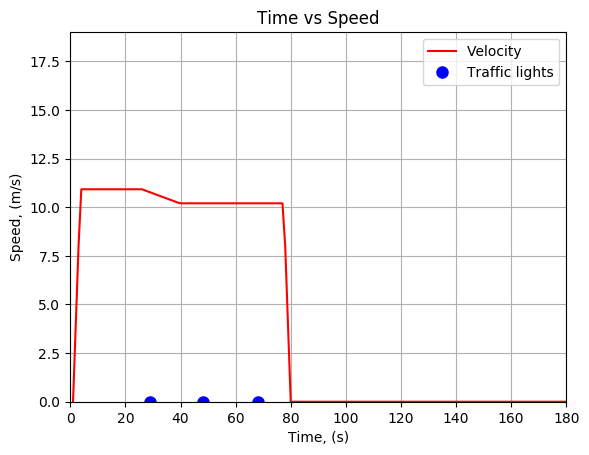

PyObject <matplotlib.legend.Legend object at 0x36aac7bd0>

In [198]:
# Plot of the Time vs Speed, Blue dots indicate the time when vehicle is near traffic light  
using PyPlot
t = [1:T;]
grid("on")
ylim(0,max_v)
xlim(0,T)
plot(t, vopt, label="Velocity", "r")

time_at_light = zeros(n_lights)
for j = 1:n_lights
    for i=1:T
        if traf_pos[j]-max_v <= xopt[i] <= traf_pos[j] + max_v
            time_at_light[j] = i
            break
        end
    end
end
plot(time_at_light, zeros(n_lights), "bo", markersize=8, label="Traffic lights")
xlabel("Time, (s)")
ylabel("Speed, (m/s)")
title("Time vs Speed")
legend()

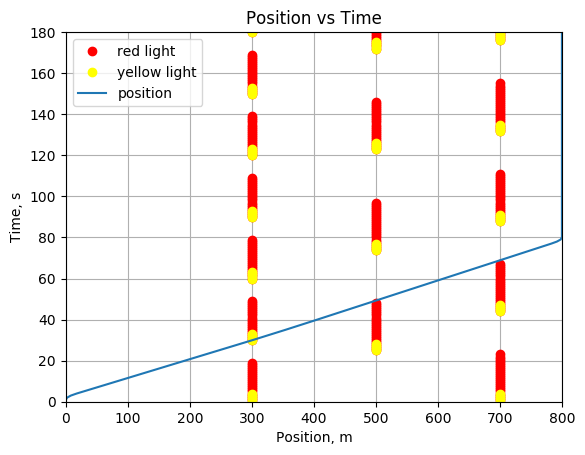

PyObject <matplotlib.legend.Legend object at 0x36d357d50>

In [199]:
# Plot of Position vs Time (includes waiting time's position)
xlim(0,destination+100)

t_lights = zeros(n_lights, T)
t_yellow = zeros(n_lights, T)

for k=1:n_lights
    count = 0
    for i=1:T
        if t_r[k,i]==0
            if count < 4
                t_yellow[k,i] = i
            end
            count = count + 1
            t_lights[k,i] = i
        else # green 
            count = 0
        end
    end
end

traf_pos_x = zeros(n_lights, T)
for k=1:n_lights
    for i in 1:T
        traf_pos_x[k,i] = traf_pos[k]
    end
end
ctr1 = 0
ctr2 = 0
for k=1:n_lights
    for i=1:T
        if t_lights[k,i]>0
            if ctr1 == 0
                plot(traf_pos_x[k,i], t_lights[k,i], "ro", label="red light")
            else
                plot(traf_pos_x[k,i], t_lights[k,i], "ro")
            end
            ctr1 = ctr1 + 1
        end
    end
    for i=1:T
        if t_yellow[k,i]>0
            if ctr2 == 0
                plot(traf_pos_x[k,i], t_yellow[k,i], color="yellow", marker="o", linestyle="None", 
                    label="yellow light")
            else
                plot(traf_pos_x[k,i], t_yellow[k,i], color="yellow", marker="o", linestyle="None") 
            end
            ctr2 = ctr2 + 1
        end
    end
end
plot(xopt,t, label = "position")
ylim(0, T)
xlim(0, destination)
grid("on")
xlabel("Position, m")
ylabel("Time, s")
title("Position vs Time")
legend()

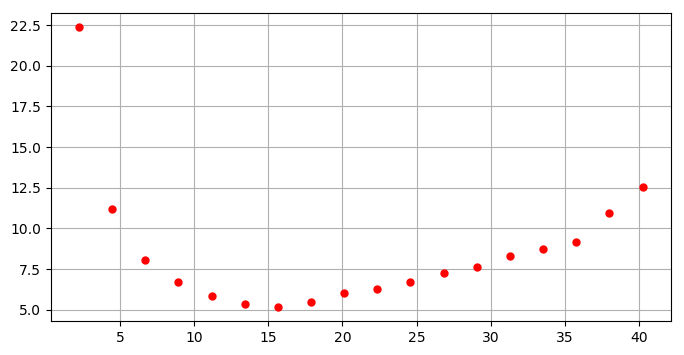

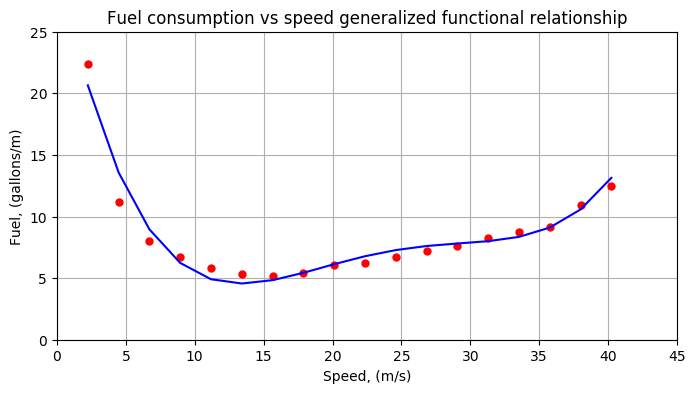

[0.000111703,-0.0108393,0.376853,-5.32999,30.7955]


In [11]:
# define (x,y) coordinates of the points
x_m = [ 5,  10, 15, 20, 25, 30, 35,   40,   45,   50,   55,   60,   65,   70,   75, 80, 85, 90 ]
y_m = [ 50, 25, 18, 15, 13, 12, 11.5, 12.2, 13.5, 14,   15,   16.2,   17,   18.5,   19.5, 20.5, 24.5, 28 ]
x = 0.44704 .* x_m
y = 0.44704 .* y_m

using PyPlot
figure(figsize=(8,4))
plot(x,y,"r.", markersize=10)
#xlim([0,10]); 
#ylim([0,55])
grid("on")
# order of polynomial to use
k = 4

# fit using a function of the form f(x) = u1 x^k + u2 x^(k-1) + ... + uk x + u{k+1}
n = length(x)
A = zeros(n,k+1)
for i = 1:n
    for j = 1:k+1
        A[i,j] = x[i]^(k+1-j)
    end
end

# NOTE: must have either Gurobi or Mosek installed!

using JuMP, Gurobi, Mosek

#m = Model(solver=MosekSolver(LOG=0))
m = Model(solver=GurobiSolver(OutputFlag=0))

@variable(m, u[1:k+1])
@objective(m, Min, sum( (y - A*u).^2 ) )
solve(m)
uopt = getvalue(u)
println(uopt)

using PyPlot
npts = length(x)
xfine = x #linspace(1,90,npts)
ffine = ones(npts)
for j = 1:k
    ffine = [ffine.*xfine ones(npts)]
end
yfine = ffine * uopt
figure(figsize=(8,4))
plot( x, y, "r.", markersize=10)
plot( xfine, yfine, "b-")
xlabel("Speed, (m/s)")
ylabel("Fuel, (gallons/m)")
title("Fuel consumption vs speed generalized functional relationship")
xlim(0,45)
ylim(0,25)
grid("on")
#xlim([0,10]); 
#ylim([0,55]); grid()

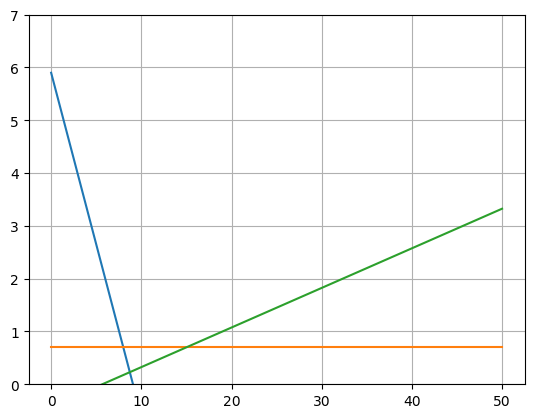

(0,7)

In [56]:
using PyPlot
v = [0:50;]
d = zeros(51)
for i=1:51
    d[i] = 7*0.1
end
plot(v, 0.1(-13/2.*v+59))
plot(v,d)
plot(v, 0.1(3/4.*v-17/4))
grid("on")
ylim(0,7)
xlim(0,)

3) report 

fuel model - penalizes for too low and to high velocities due to air resistance

fuel obj-  fuel-velocity , change in velocity, fuel consumed while stopping until you reach destination

multiple traffic lights

traffic - 
show - draw a diagram of the position and time of the vehicle, and the time bars for the red lights 

analysis - savings in fuel

---------------------------------------------------
limit for the acceleration max and min for stopping also 
minimizing fuel consumption only right now 
minimize jerk 
acceleration, derivative of acceleration 

quadratic speed decrease 

not consuming fuel when you hit breaks
current velocity plus current acceleration 

higher gears are more efficient 60miles per hour
discrete problem, for different gears different fuel efficiency 

is it different for truck or a car ? 

keep model simplified and add traffic lights 